In [158]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt


# 설치된 글꼴 이름 파악을 위해서!!
import matplotlib as mpl
from matplotlib import font_manager as fm
from matplotlib import rc

# 설정 파일 위치 확인
print(mpl.matplotlib_fname())
print(mpl.__file__)

# Jupyter Notebook 로드 시 같이 올라온 font 목록 확인
[f.fname for f in fm.fontManager.ttflist]	# NanumGothic.ttf 목록에서 확인 완료!!!

# NanumGothic 설정 확인
plt.rcParams['font.family'] = 'NanumGothic'
print(plt.rcParams['font.family'])		# NanumGothic 설정 제대로 먹힌 것을 확인!!!

# 마이너스(-)가 '□'로 깨지는 것을 방지하기 위하여 설정!!!
mpl.rcParams['axes.unicode_minus'] = False

/home/ubuntu/anaconda3/envs/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc
/home/ubuntu/anaconda3/envs/venv/lib/python3.10/site-packages/matplotlib/__init__.py
['NanumGothic']


# 데이터 전처리

In [159]:
df = pd.read_csv('1004_df.csv')

df['date'] = df['date'].astype(int)

df['gender'].replace({'M':0, 'F':1}, inplace=True)

age_list = []
for age in df['age']:
    if age[1:] == '0e':
        age = age[0] + '0'
    else:
        age = age[0] + '5'

    # age_list.append(int(age))
    age_list.append(age)

df['age'] = age_list

null_values = df[df['lf04r'].isnull()]
not_null_values = df[df['lf04r'].notnull()]

df['UseLife'] = 9999
df.loc[null_values.index, 'UseLife'] = 0
df.loc[not_null_values.index, 'UseLife'] = 1

df.drop(columns=['구명'], inplace=True)

/tmp/ipykernel_184373/1057980573.py:1: DtypeWarning: Columns (435) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('1004_df.csv')


# 외부 데이터 추가 (행정동별 연령별 인구수)

In [160]:
plus_df = pd.read_csv("AllAge_plus_data.csv", encoding='cp949')

plus_df.columns = ['행정동명', 'age', 'del', 'del2', '2208', '2210', '2212', '2302', '2304', '2306']
plus_df['age'] = plus_df['age'].str[:2]

col = ['del', 'del2']
plus_df.drop(columns=col, inplace=True)

In [161]:
inner = pd.merge(df, plus_df, on=['행정동명', 'age'], how='inner')
# left = pd.merge(df, plus_df, on=['행정동명', 'age'], how='left')
# outer = pd.merge(df, plus_df, on=['행정동명', 'age'], how='outer')

In [162]:
print(f" inner 조인 후 누락된 값의 비율 : {(len(df) - len(inner)) / len(df)}")

 inner 조인 후 누락된 값의 비율 : 0.11832460732984293


In [163]:
year_list = inner.columns[-6:]

new_list =  []
num = 9999

for idx, date in enumerate(inner['date']):
    for idx2, date2 in enumerate(year_list):
        if str(date) == date2:
            num = idx2
    new_list.append(inner.iloc[idx][year_list[num]])

inner['value'] = new_list
inner.drop(columns = ['2208','2210','2212','2302','2304','2306'], inplace=True)

# 데이터 시각화

## 2030 vs 외 연령 이용 금액 비교

In [120]:
inner_ca01m = inner[~inner['ca01m'].isnull()]

young_ages = ['20', '25', '30', '35']

# 'young_vs_old' 열을 모두 'old'로 초기화
inner_ca01m['young_vs_old'] = 'old'

# 'age'가 'young_ages'에 속하는 행에 대해 'young_vs_old' 값을 'young'으로 설정
inner_ca01m.loc[inner_ca01m['age'].isin(young_ages), 'young_vs_old'] = 'young'

/tmp/ipykernel_184373/3109290304.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner_ca01m['young_vs_old'] = 'old'


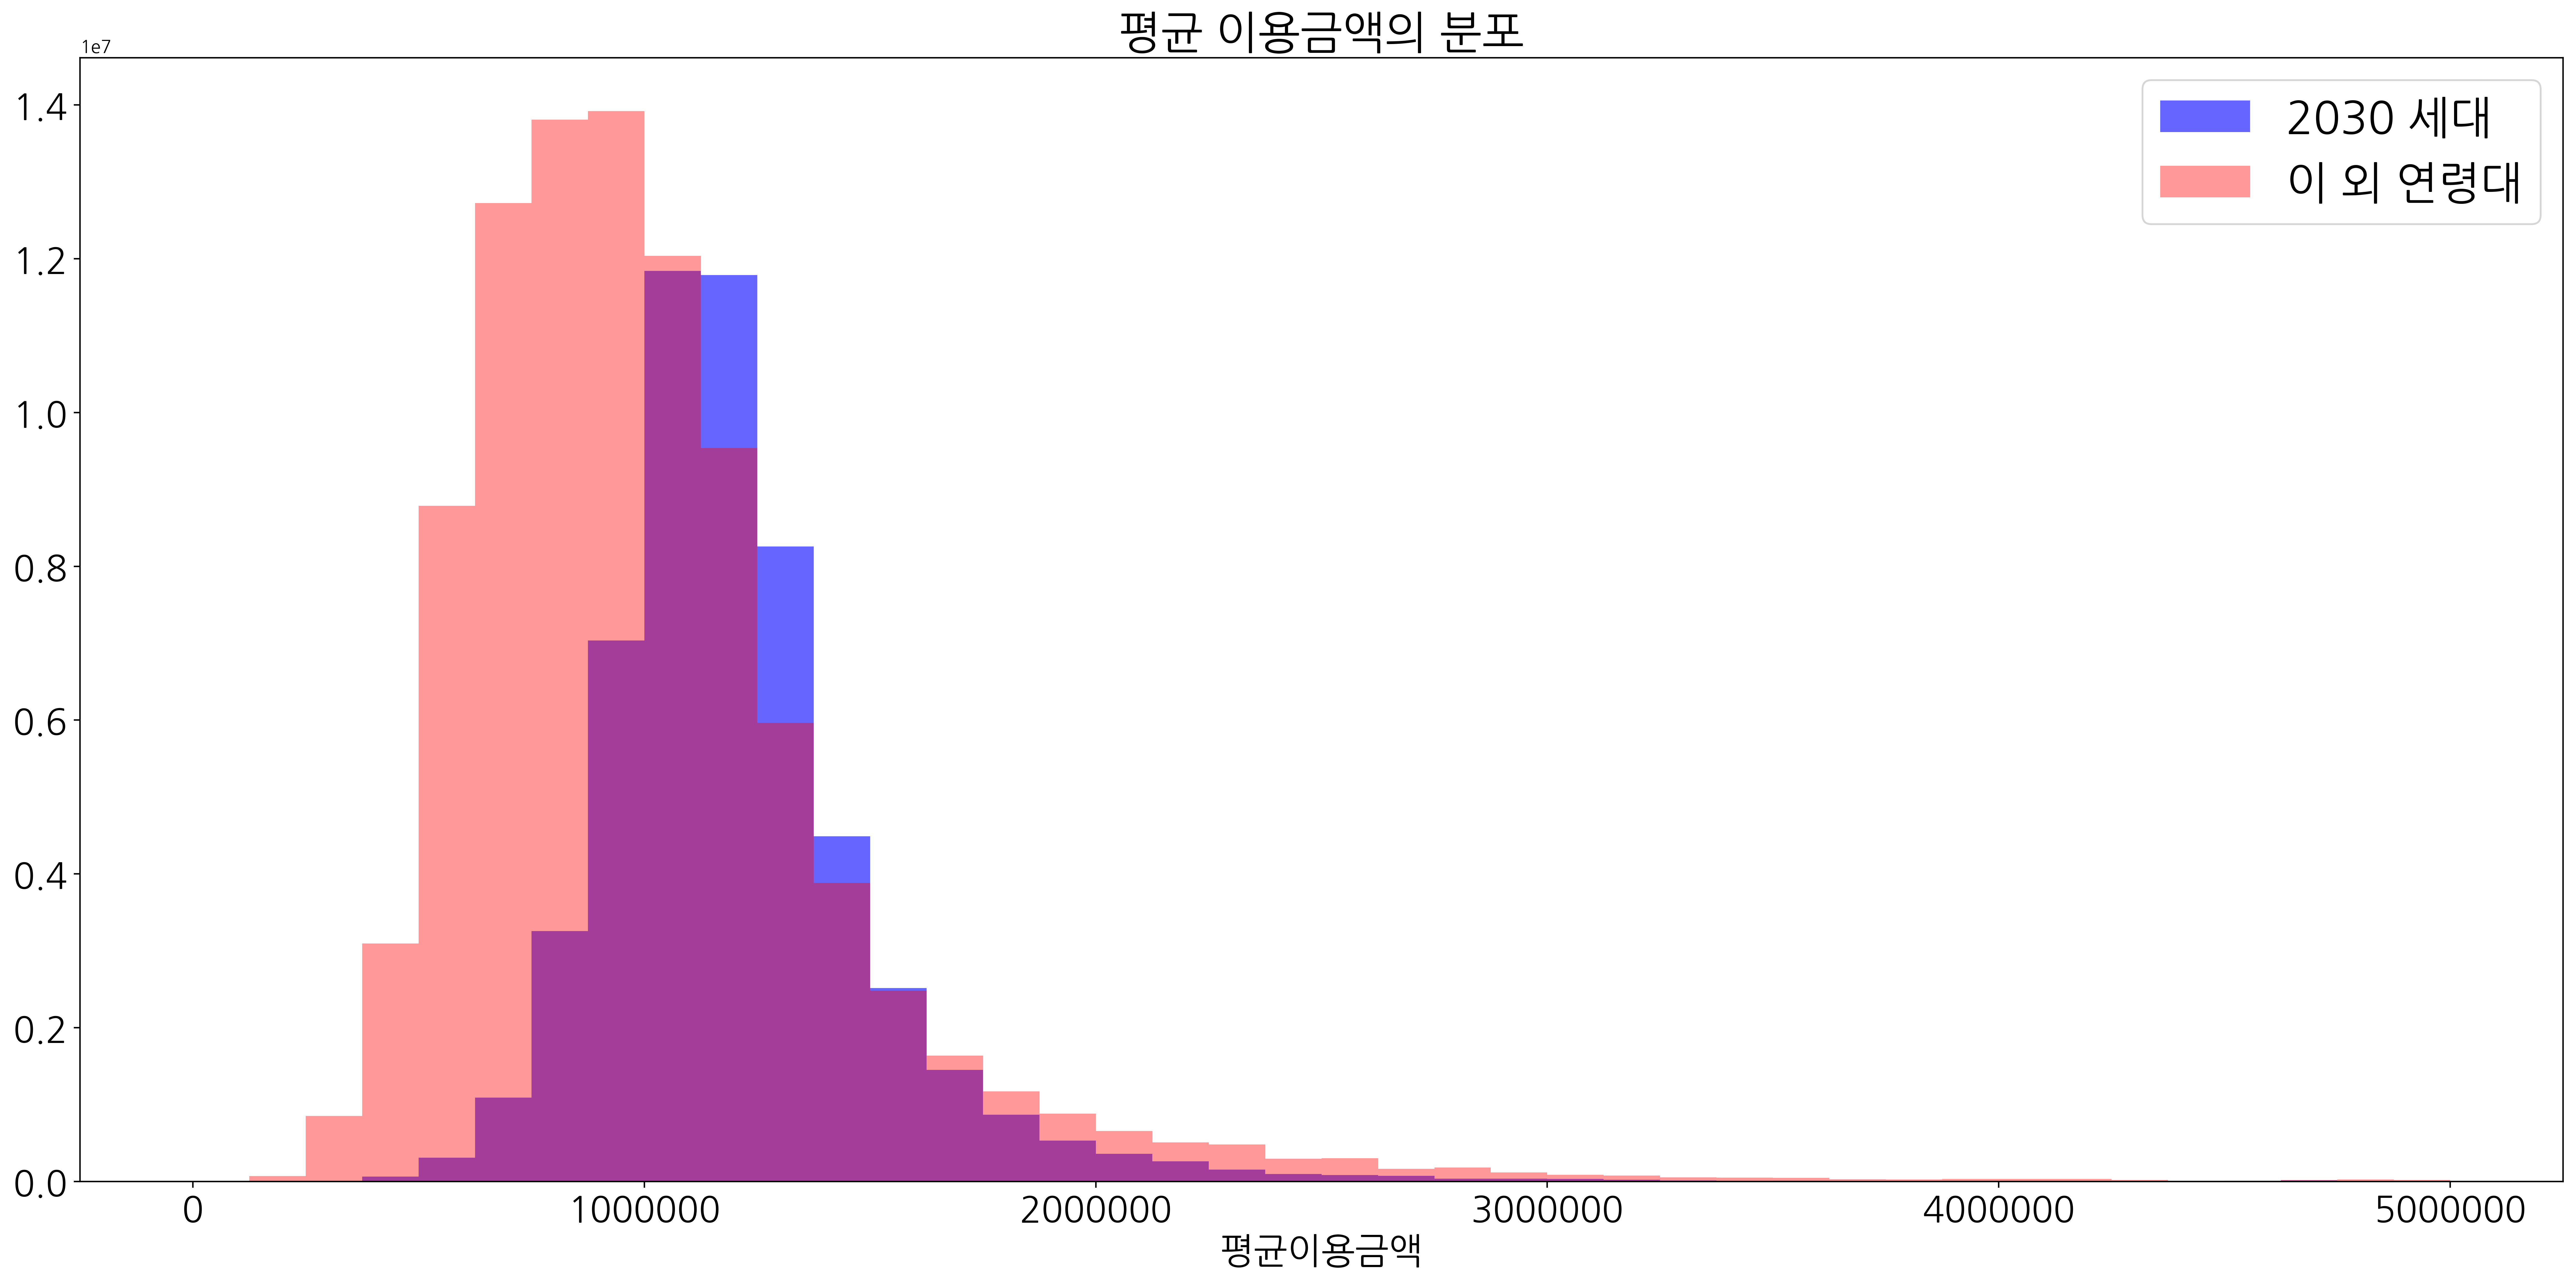

In [122]:
x_range = (0, 5000000)

# young_df와 other_ages_df에서 'young_vs_old'가 'young'인 행과 'old'인 행을 각각 추출
young_df_young = inner_ca01m[inner_ca01m['young_vs_old'] == 'young']
young_df_old = inner_ca01m[inner_ca01m['young_vs_old'] == 'old']


# 각각의 히스토그램을 그릴 때 'value'를 가중치로 사용
plt.figure(figsize=(20, 10), dpi=500)
plt.hist(young_df_young['ca01m'], bins=40, alpha=0.6, label='2030 세대', color='b', weights=young_df_young['value'], range=x_range)
plt.hist(young_df_old['ca01m'], bins=40, alpha=0.4, label='이 외 연령대', color='r', weights=young_df_old['value'], range=x_range)

plt.title('평균 이용금액의 분포', fontsize=25)
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.xlabel('평균이용금액', fontsize=20)
plt.legend(fontsize=25)

plt.tick_params(axis='both', labelsize=20)

plt.tight_layout()

plt.savefig('1.이용금액 분포.png')

plt.show()

In [22]:
from scipy.stats import ttest_ind

# 'young_vs_old'가 'young'인 그룹과 'old'인 그룹의 평균 이용금액에 대해 t-검정 수행
t_stat, p_value = ttest_ind(young_df_young['ca01m'], young_df_old['ca01m'])
formatted_p_value = f"{p_value:.3f}"


# p-value를 기준으로 유의수준을 선택하여 결과를 해석
alpha = 0.05
print(f"T-statistic: {t_stat:.3f}, p-value: {formatted_p_value}")
print()

if p_value < alpha:
    print("두 그룹 간에는 통계적으로 유의한 평균 차이가 있습니다.")
else:
    print("두 그룹 간에는 통계적으로 유의한 평균 차이가 없습니다.")

T-statistic: 69.231, p-value: 0.000

두 그룹 간에는 통계적으로 유의한 평균 차이가 있습니다.


## 주택 대출 평잔 / 총 대출 평잔

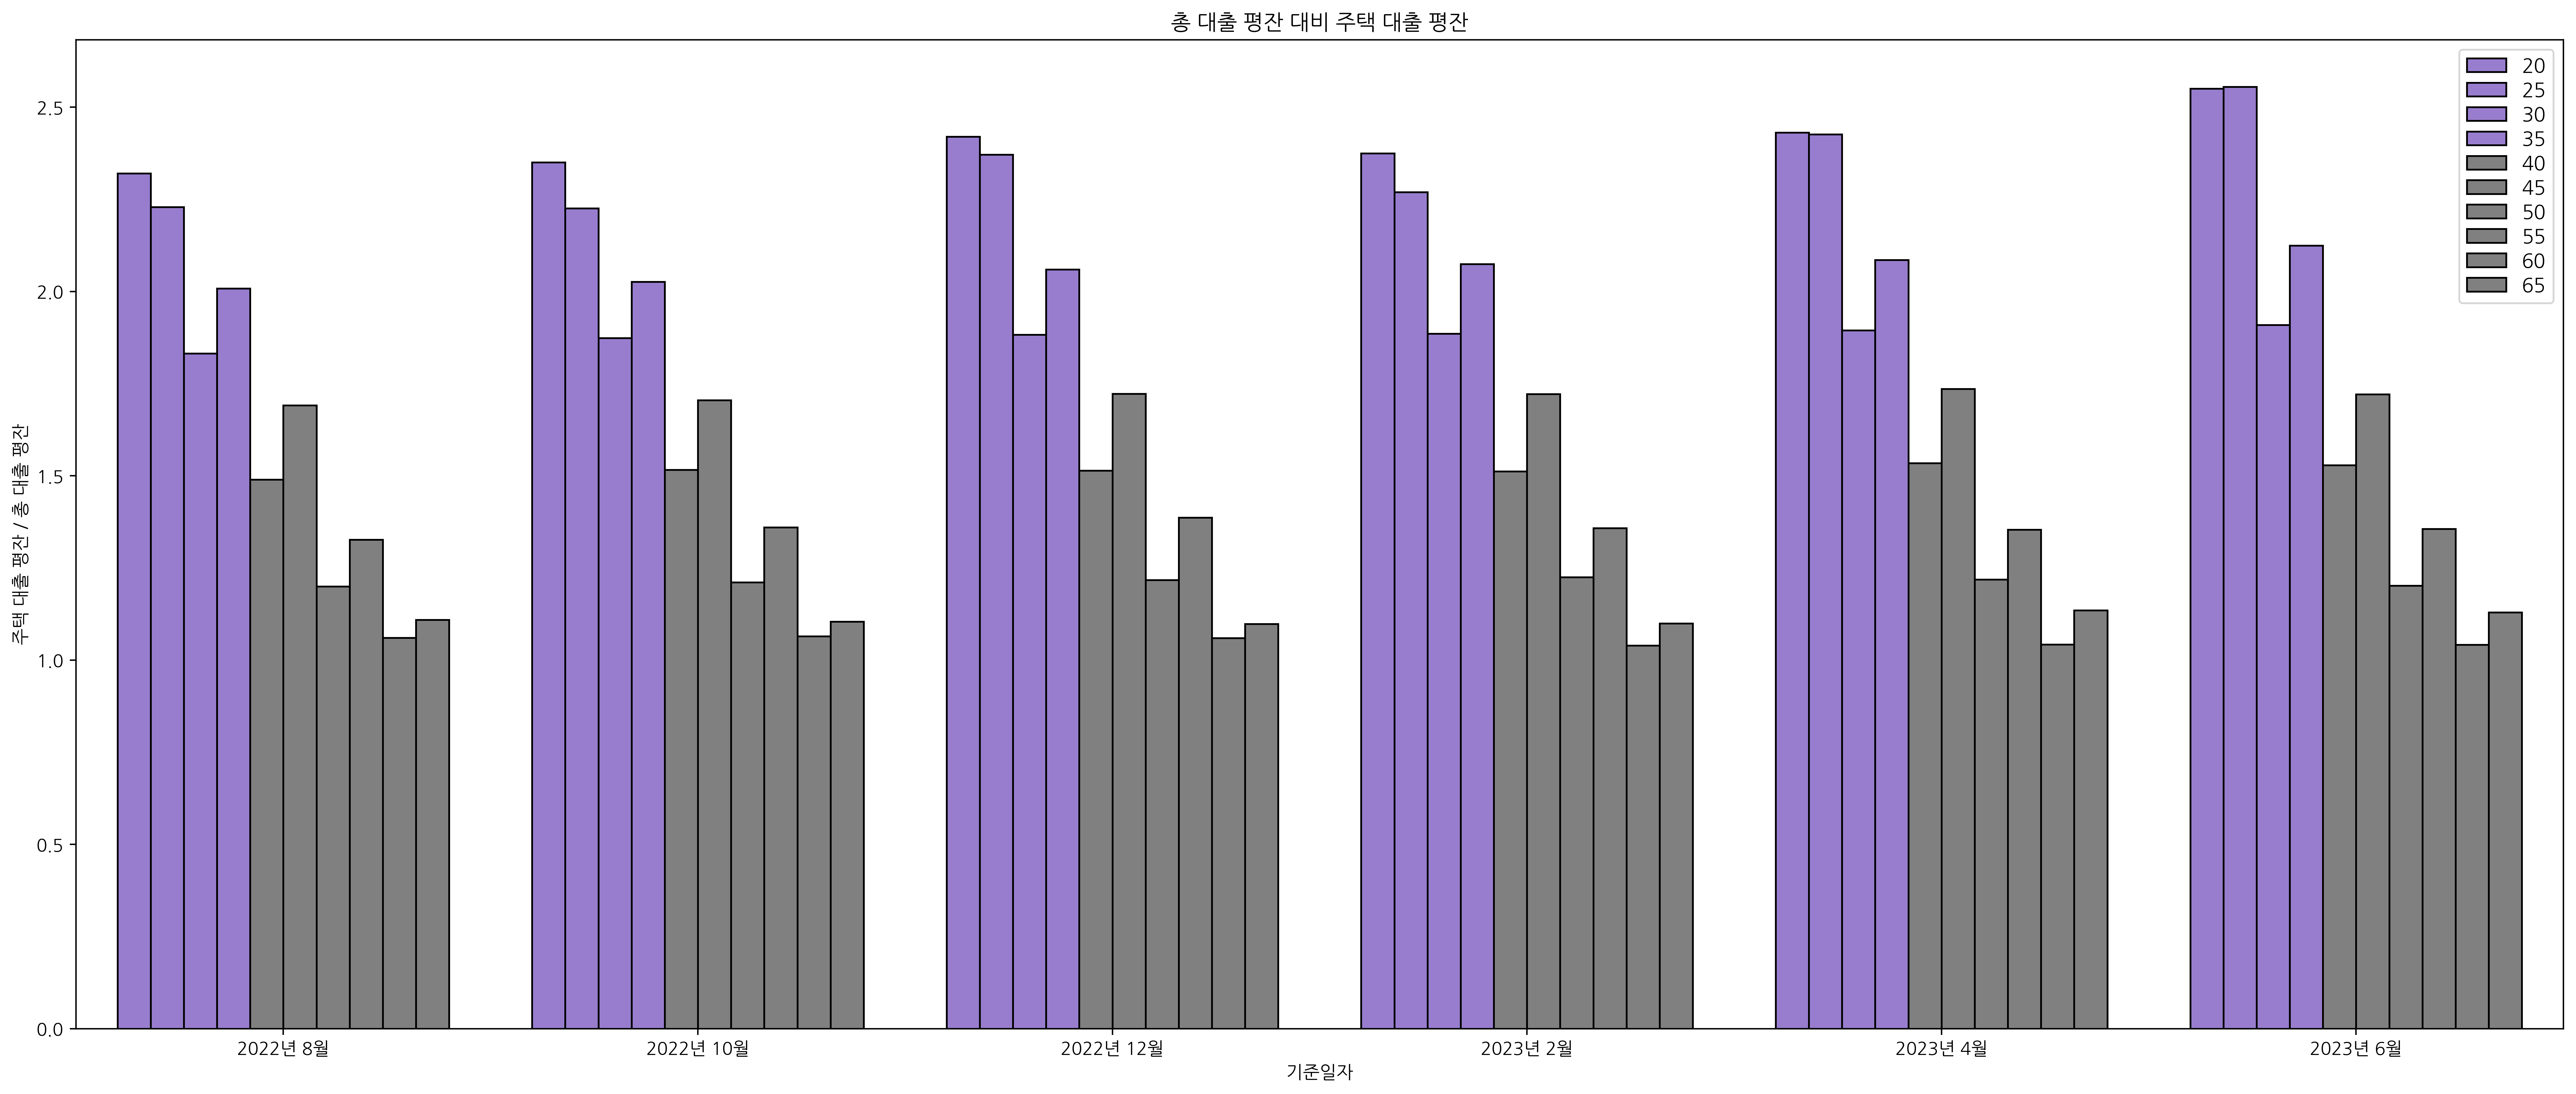

In [123]:
inner['new_bb'] = inner['bb08m'] / inner['bb02m']
inner_loan = inner[inner['new_bb'].notnull()]

# 가중 평균 계산 함수
def weighted_avg(group):
    total_value = group['value'].sum()
    if total_value != 0:
        return np.average(group['new_bb'], weights=group['value'])
    else:
        return 0

# date와 age를 기준으로 그룹화하고 각 그룹에 대해 가중 평균을 계산
result = inner_loan.groupby(['date', 'age']).apply(weighted_avg).reset_index(name='weighted_avg')

# 그래프 설정
ages = ['20', '25', '30', '35', '40', '45', '50', '55', '60', '65']
plt.figure(figsize=(25, 10), dpi=500)
palette = {age: 'grey' for age in ages}
palette['20'] = 'mediumpurple'
palette['25'] = 'mediumpurple'
palette['30'] = 'mediumpurple'
palette['35'] = 'mediumpurple'

temp = '총 대출 평잔 대비 주택 대출 평잔'

# 바 플롯 그리기
sns.barplot(x='date', y='weighted_avg', hue='age', data=result, palette=palette, edgecolor='black')

# 그래프의 제목과 x, y축 라벨을 설정
plt.title(temp)
plt.xlabel('기준일자')
plt.ylabel('주택 대출 평잔 / 총 대출 평잔')

# X축 라벨 바꾸기
labels = ['2022년 8월', '2022년 10월', '2022년 12월', '2023년 2월', '2023년 4월', '2023년 6월']
plt.xticks(range(len(labels)), labels)

# 레전드 크기 조정
plt.legend(title_fontsize='10', labelspacing=0.3, fontsize=11)

plt.savefig('4.총 대출 평잔 대비 주택 대출 평잔.png')

# 그래프 표시
plt.show()


In [ ]:
# 모든 연령대에서 모든 보험료의 평균 대비 대출 평잔이 높음
# 그 중에서도 2030이 

## 소비 금액

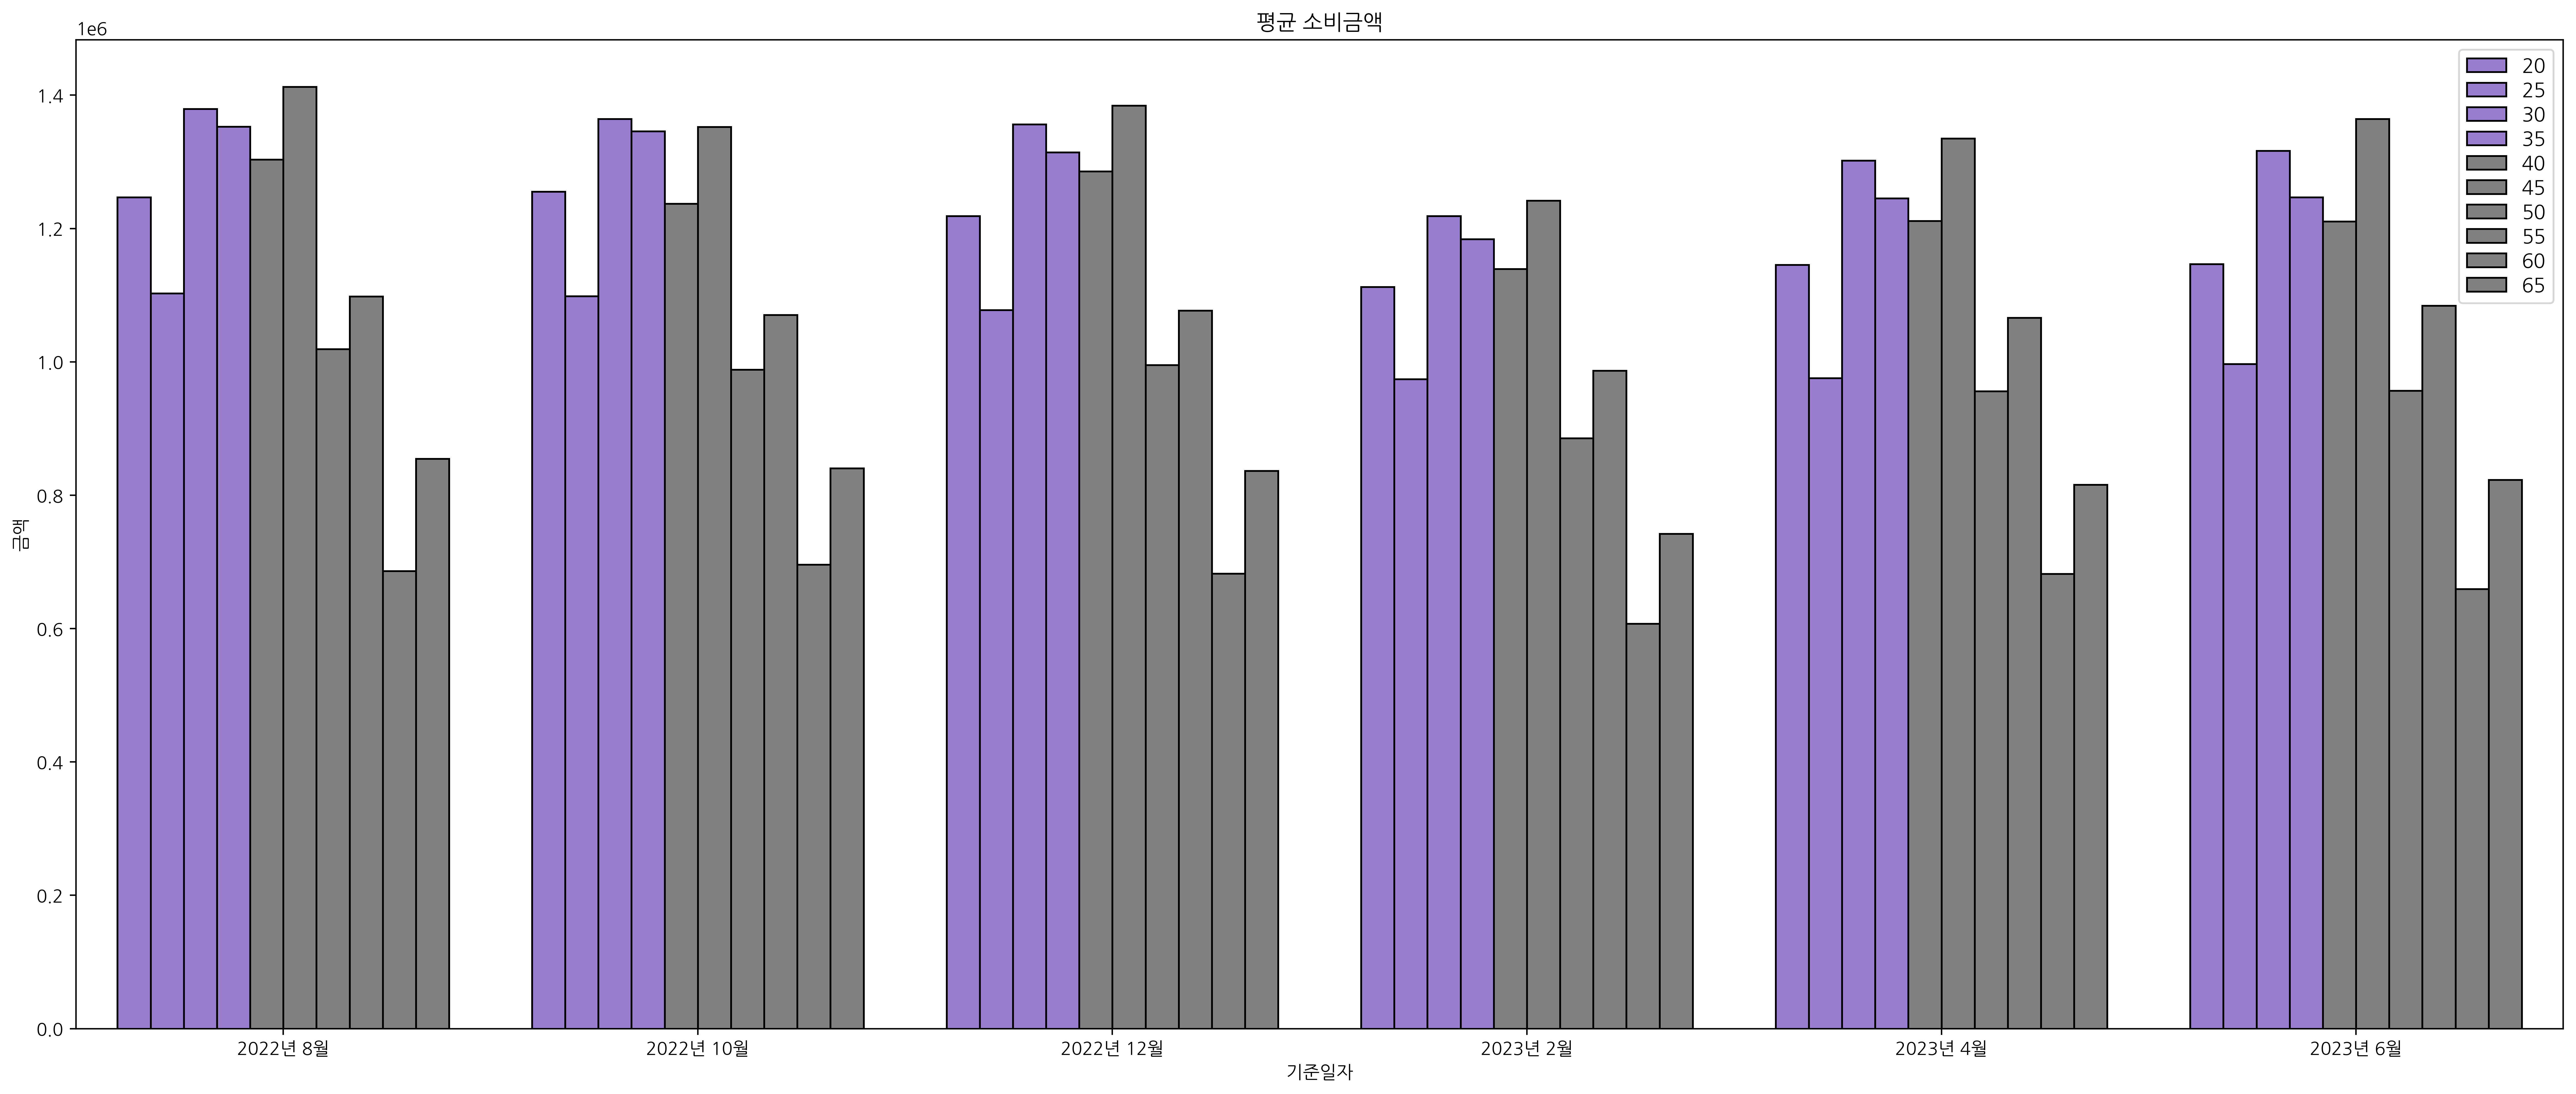

In [41]:
spend_inner_nullX = inner[inner['ca01m'].notnull()]

# 가중 평균 계산 함수
def weighted_avg(group):
    total_value = group['value'].sum()
    if total_value != 0:
        return np.average(group['ca01m'], weights=group['value'])
    else:
        return 0

# date와 age를 기준으로 그룹화하고 각 그룹에 대해 가중 평균을 계산
result = spend_inner_nullX.groupby(['date', 'age']).apply(weighted_avg).reset_index(name='weighted_avg')

# 그래프 설정
ages = ['20', '25', '30', '35', '40', '45', '50', '55', '60', '65']
plt.figure(figsize=(25, 10), dpi=500)
palette = {age: 'grey' for age in ages}
palette['20'] = 'mediumpurple'
palette['25'] = 'mediumpurple'
palette['30'] = 'mediumpurple'
palette['35'] = 'mediumpurple'

temp = '평균 소비금액'

# 바 플롯 그리기
sns.barplot(x='date', y='weighted_avg', hue='age', data=result, palette=palette, edgecolor='black')

# 그래프의 제목과 x, y축 라벨을 설정
plt.title(temp)
plt.xlabel('기준일자')
plt.ylabel('금액')

# X축 라벨 바꾸기
labels = ['2022년 8월', '2022년 10월', '2022년 12월', '2023년 2월', '2023년 4월', '2023년 6월']
plt.xticks(range(len(labels)), labels)

# 레전드 크기 조정
plt.legend(title_fontsize='10', labelspacing=0.3, fontsize=11)

plt.savefig('연령, 기준일자별 평균 소비금액.png')

# 그래프 표시
plt.show()


## 최근 1년 변액 보험 계약 고객 비율

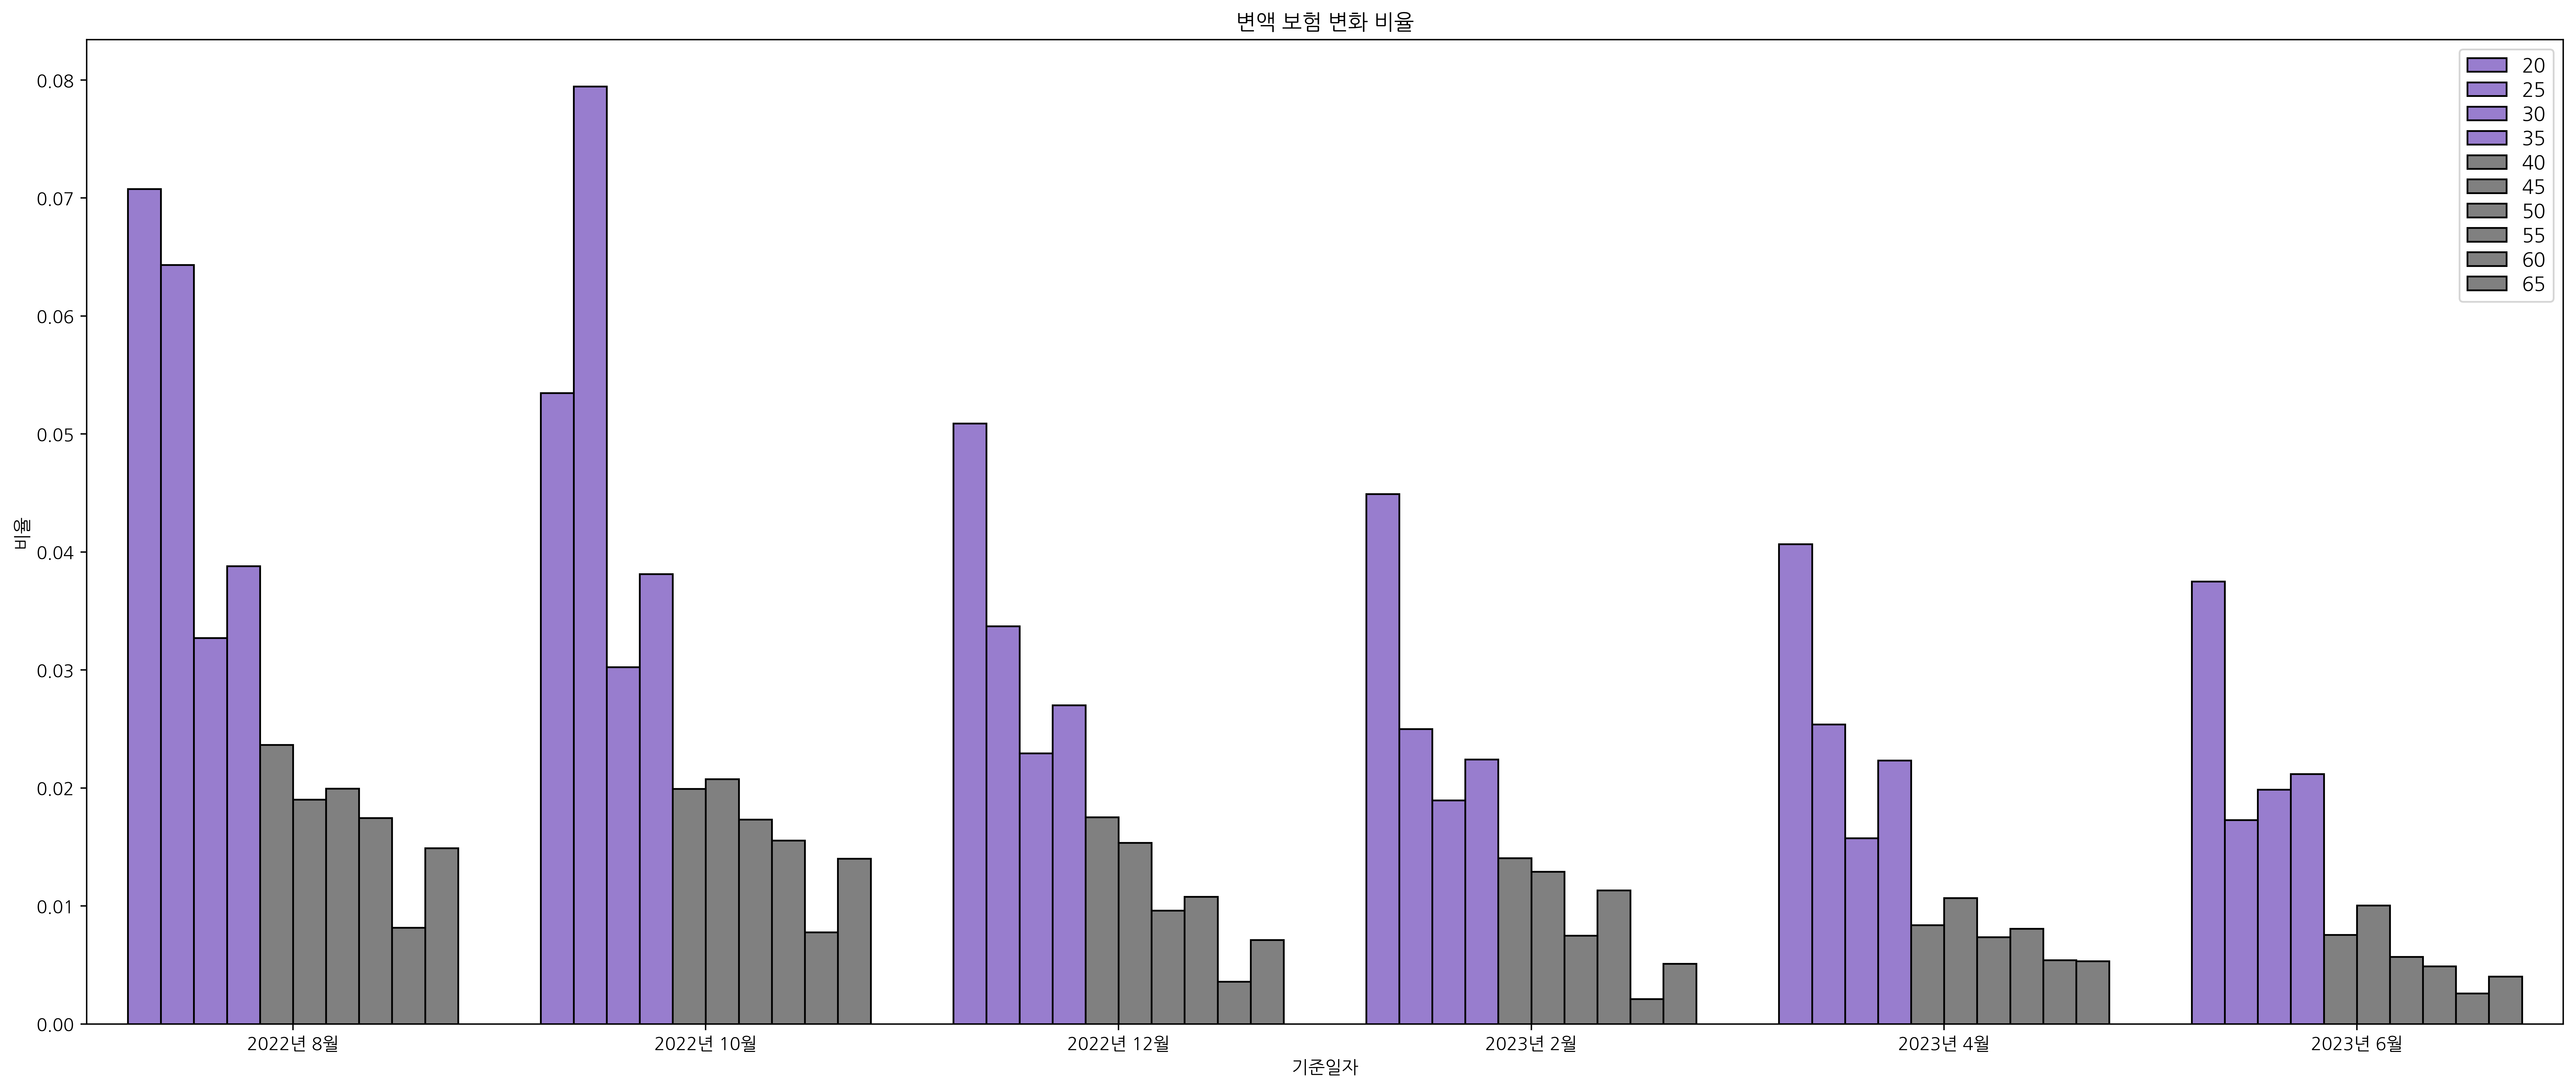

In [128]:
inner_recent_year = inner[inner['la06r'].notnull()]

# 가중 평균 계산 함수
def weighted_avg(group):
    total_value = group['value'].sum()
    if total_value != 0:
        return np.average(group['la06r'], weights=group['value'])
    else:
        return 0

# date와 age를 기준으로 그룹화하고 각 그룹에 대해 가중 평균을 계산
result = inner_recent_year.groupby(['date', 'age']).apply(weighted_avg).reset_index(name='weighted_avg')

# 그래프 설정
ages = ['20', '25', '30', '35', '40', '45', '50', '55', '60', '65']
plt.figure(figsize=(25, 10), dpi=500)
palette = {age: 'grey' for age in ages}
palette['20'] = 'mediumpurple'
palette['25'] = 'mediumpurple'
palette['30'] = 'mediumpurple'
palette['35'] = 'mediumpurple'

temp = '변액 보험 변화 비율'

# 바 플롯 그리기
sns.barplot(x='date', y='weighted_avg', hue='age', data=result, palette=palette, edgecolor='black')

# 그래프의 제목과 x, y축 라벨을 설정
plt.title(temp)
plt.xlabel('기준일자')
plt.ylabel('비율')

# X축 라벨 바꾸기
labels = ['2022년 8월', '2022년 10월', '2022년 12월', '2023년 2월', '2023년 4월', '2023년 6월']
plt.xticks(range(len(labels)), labels)

# 레전드 크기 조정
plt.legend(title_fontsize='10', labelspacing=0.3, fontsize=11)

plt.savefig('5.변액 보험 변화 비율.png')

# 그래프 표시
plt.show()


## 최근 1년 연금저축 보험계약 고객 비율

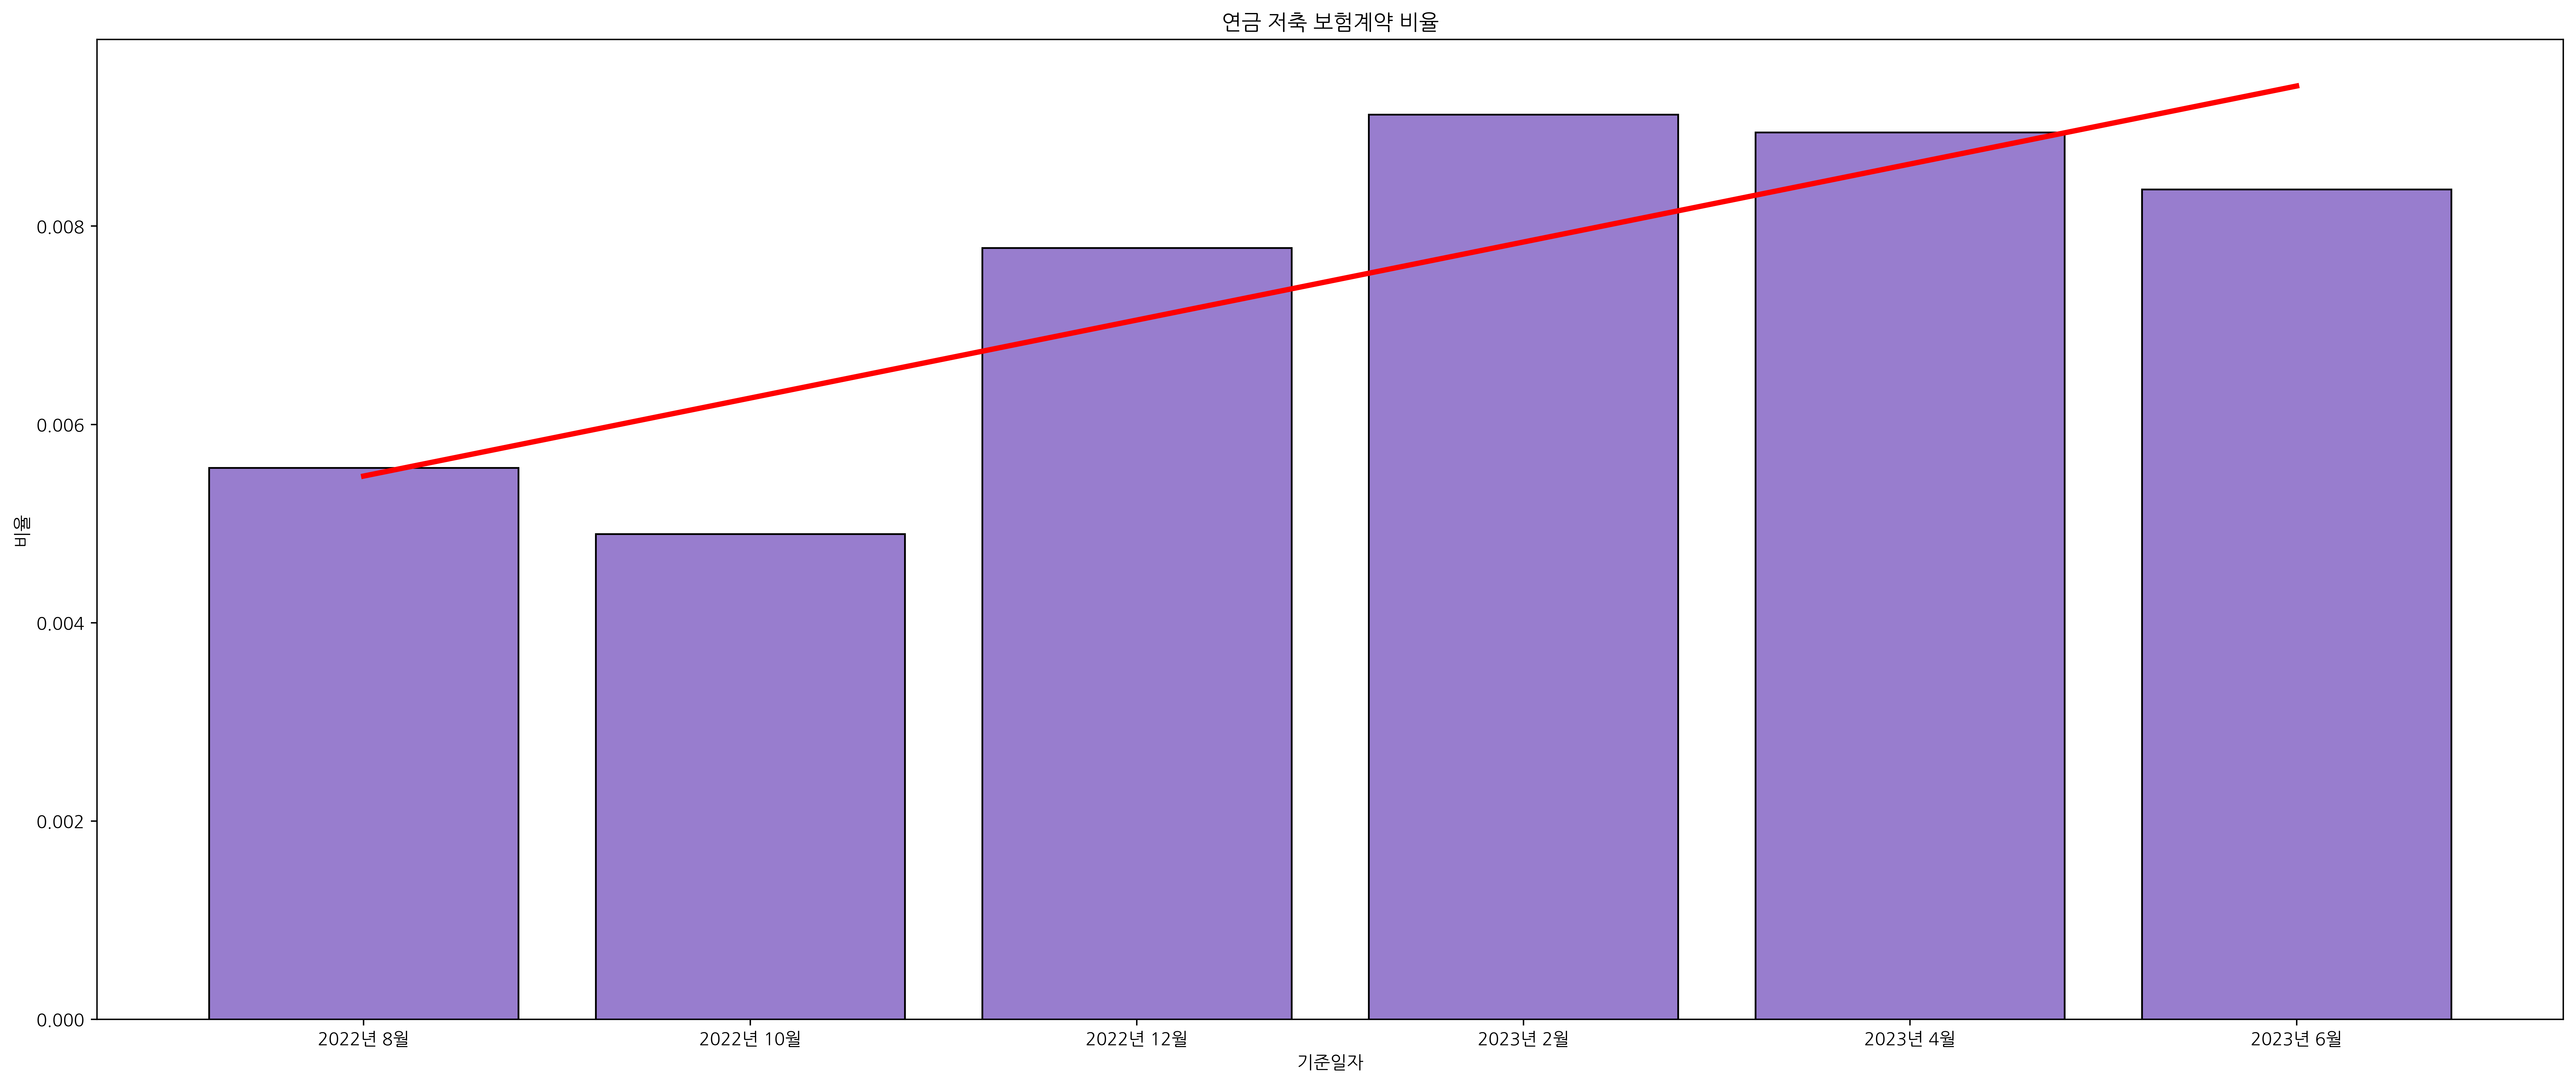

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# 가중 평균 계산 함수
def weighted_avg(group):
    total_value = group['value'].sum()
    if total_value != 0:
        return np.average(group['la05r'], weights=group['value'])
    else:
        return 0

# 날짜를 기준으로 모든 나이에 대한 가중 평균 계산
date_weighted_avg = new_first.groupby('date').apply(weighted_avg).reset_index(name='weighted_avg')

# 그래프 설정
plt.figure(figsize=(25, 10), dpi=500)

temp = '연금 저축 보험계약 비율'

# 바 플롯 그리기 (모든 나이의 가중 평균)
sns.barplot(x='date', y='weighted_avg', data=date_weighted_avg, color='mediumpurple', edgecolor='black')

# 추세선을 위한 데이터
x_dates = date_weighted_avg['date'].unique()  # 중복을 제거한 date 값
x_indices = np.arange(len(x_dates))  # x축 인덱스

# 선형 회귀 모델로 추세선 계수 계산
slope, intercept, _, _, _ = linregress(x_indices, date_weighted_avg['weighted_avg'])

# 추세선 그리기
plt.plot(x_indices, intercept + slope * x_indices, color='red', label='Trendline', linewidth=3)  # linewidth=2로 두껍게 설정

# 그래프의 제목과 x, y축 라벨을 설정
plt.title(temp)
plt.xlabel('기준일자')
plt.ylabel('비율')

# X축 라벨 바꾸기
labels = ['2022년 8월', '2022년 10월', '2022년 12월', '2023년 2월', '2023년 4월', '2023년 6월']
plt.xticks(range(len(labels)), labels)

# 저장
plt.savefig('5.연금 저축 보험 계약3.png')

# 그래프 표시
plt.show()


## 변약 보험계약 고객 비율

In [140]:
inner_lb06r = inner[~inner['lb06r'].isnull()]

young_ages = ['20', '25', '30', '35']

# 'young_vs_old' 열을 모두 'old'로 초기화
inner_lb06r['young_vs_old'] = 'old'

# 'age'가 'young_ages'에 속하는 행에 대해 'young_vs_old' 값을 'young'으로 설정
inner_lb06r.loc[inner_lb06r['age'].isin(young_ages), 'young_vs_old'] = 'young'

/tmp/ipykernel_184373/213741563.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner_lb06r['young_vs_old'] = 'old'


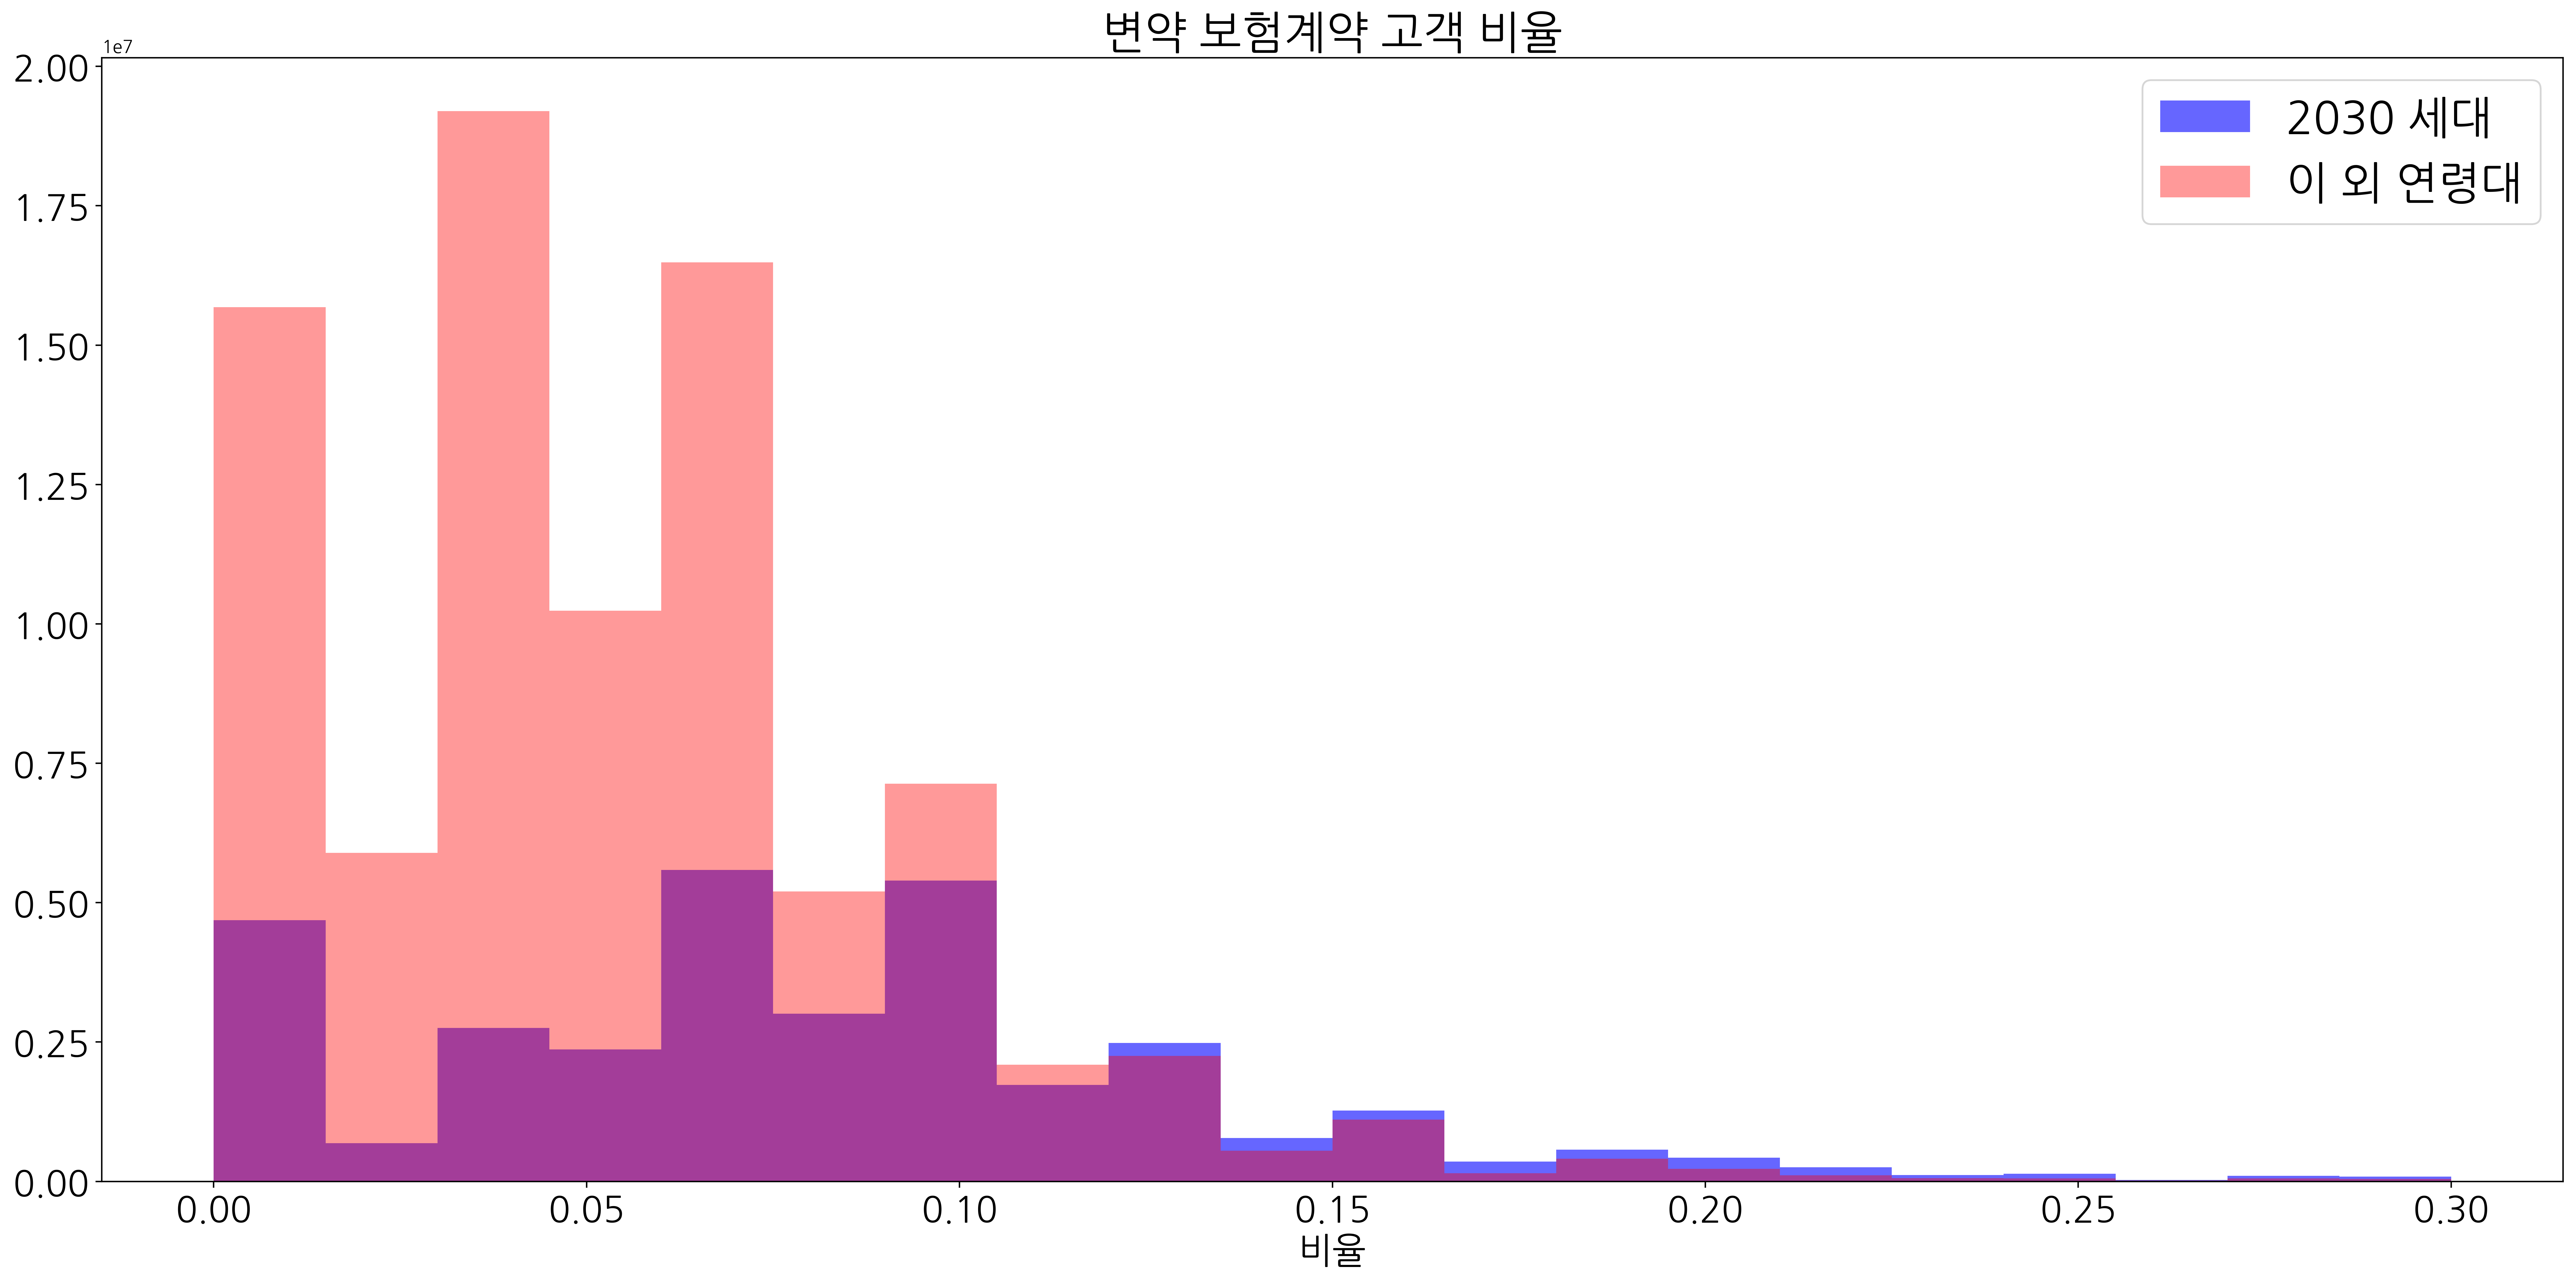

In [157]:
x_range = (0, 0.3)

# young_df와 other_ages_df에서 'young_vs_old'가 'young'인 행과 'old'인 행을 각각 추출
young_df_young = inner_lb06r[inner_lb06r['young_vs_old'] == 'young']
young_df_old = inner_lb06r[inner_lb06r['young_vs_old'] == 'old']


# 각각의 히스토그램을 그릴 때 'value'를 가중치로 사용
plt.figure(figsize=(20, 10), dpi=500)
plt.hist(young_df_young['lb06r'], bins=20, alpha=0.6, label='2030 세대', color='b', weights=young_df_young['value'], range=x_range)
plt.hist(young_df_old['lb06r'], bins=20, alpha=0.4, label='이 외 연령대', color='r', weights=young_df_old['value'], range=x_range)

plt.title('변약 보험계약 고객 비율', fontsize=25)
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.xlabel('비율', fontsize=20)
plt.legend(fontsize=25)

plt.tick_params(axis='both', labelsize=20)

plt.tight_layout()

plt.savefig('new2.png')

plt.show()

## 연금저축 보험계약 고객비율

In [149]:
inner_lb05r = inner[~inner['lb05r'].isnull()]

young_ages = ['20', '25', '30', '35']

# 'young_vs_old' 열을 모두 'old'로 초기화
inner_lb05r['young_vs_old'] = 'old'

# 'age'가 'young_ages'에 속하는 행에 대해 'young_vs_old' 값을 'young'으로 설정
inner_lb05r.loc[inner_lb05r['age'].isin(young_ages), 'young_vs_old'] = 'young'

/tmp/ipykernel_184373/3449236409.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner_lb05r['young_vs_old'] = 'old'


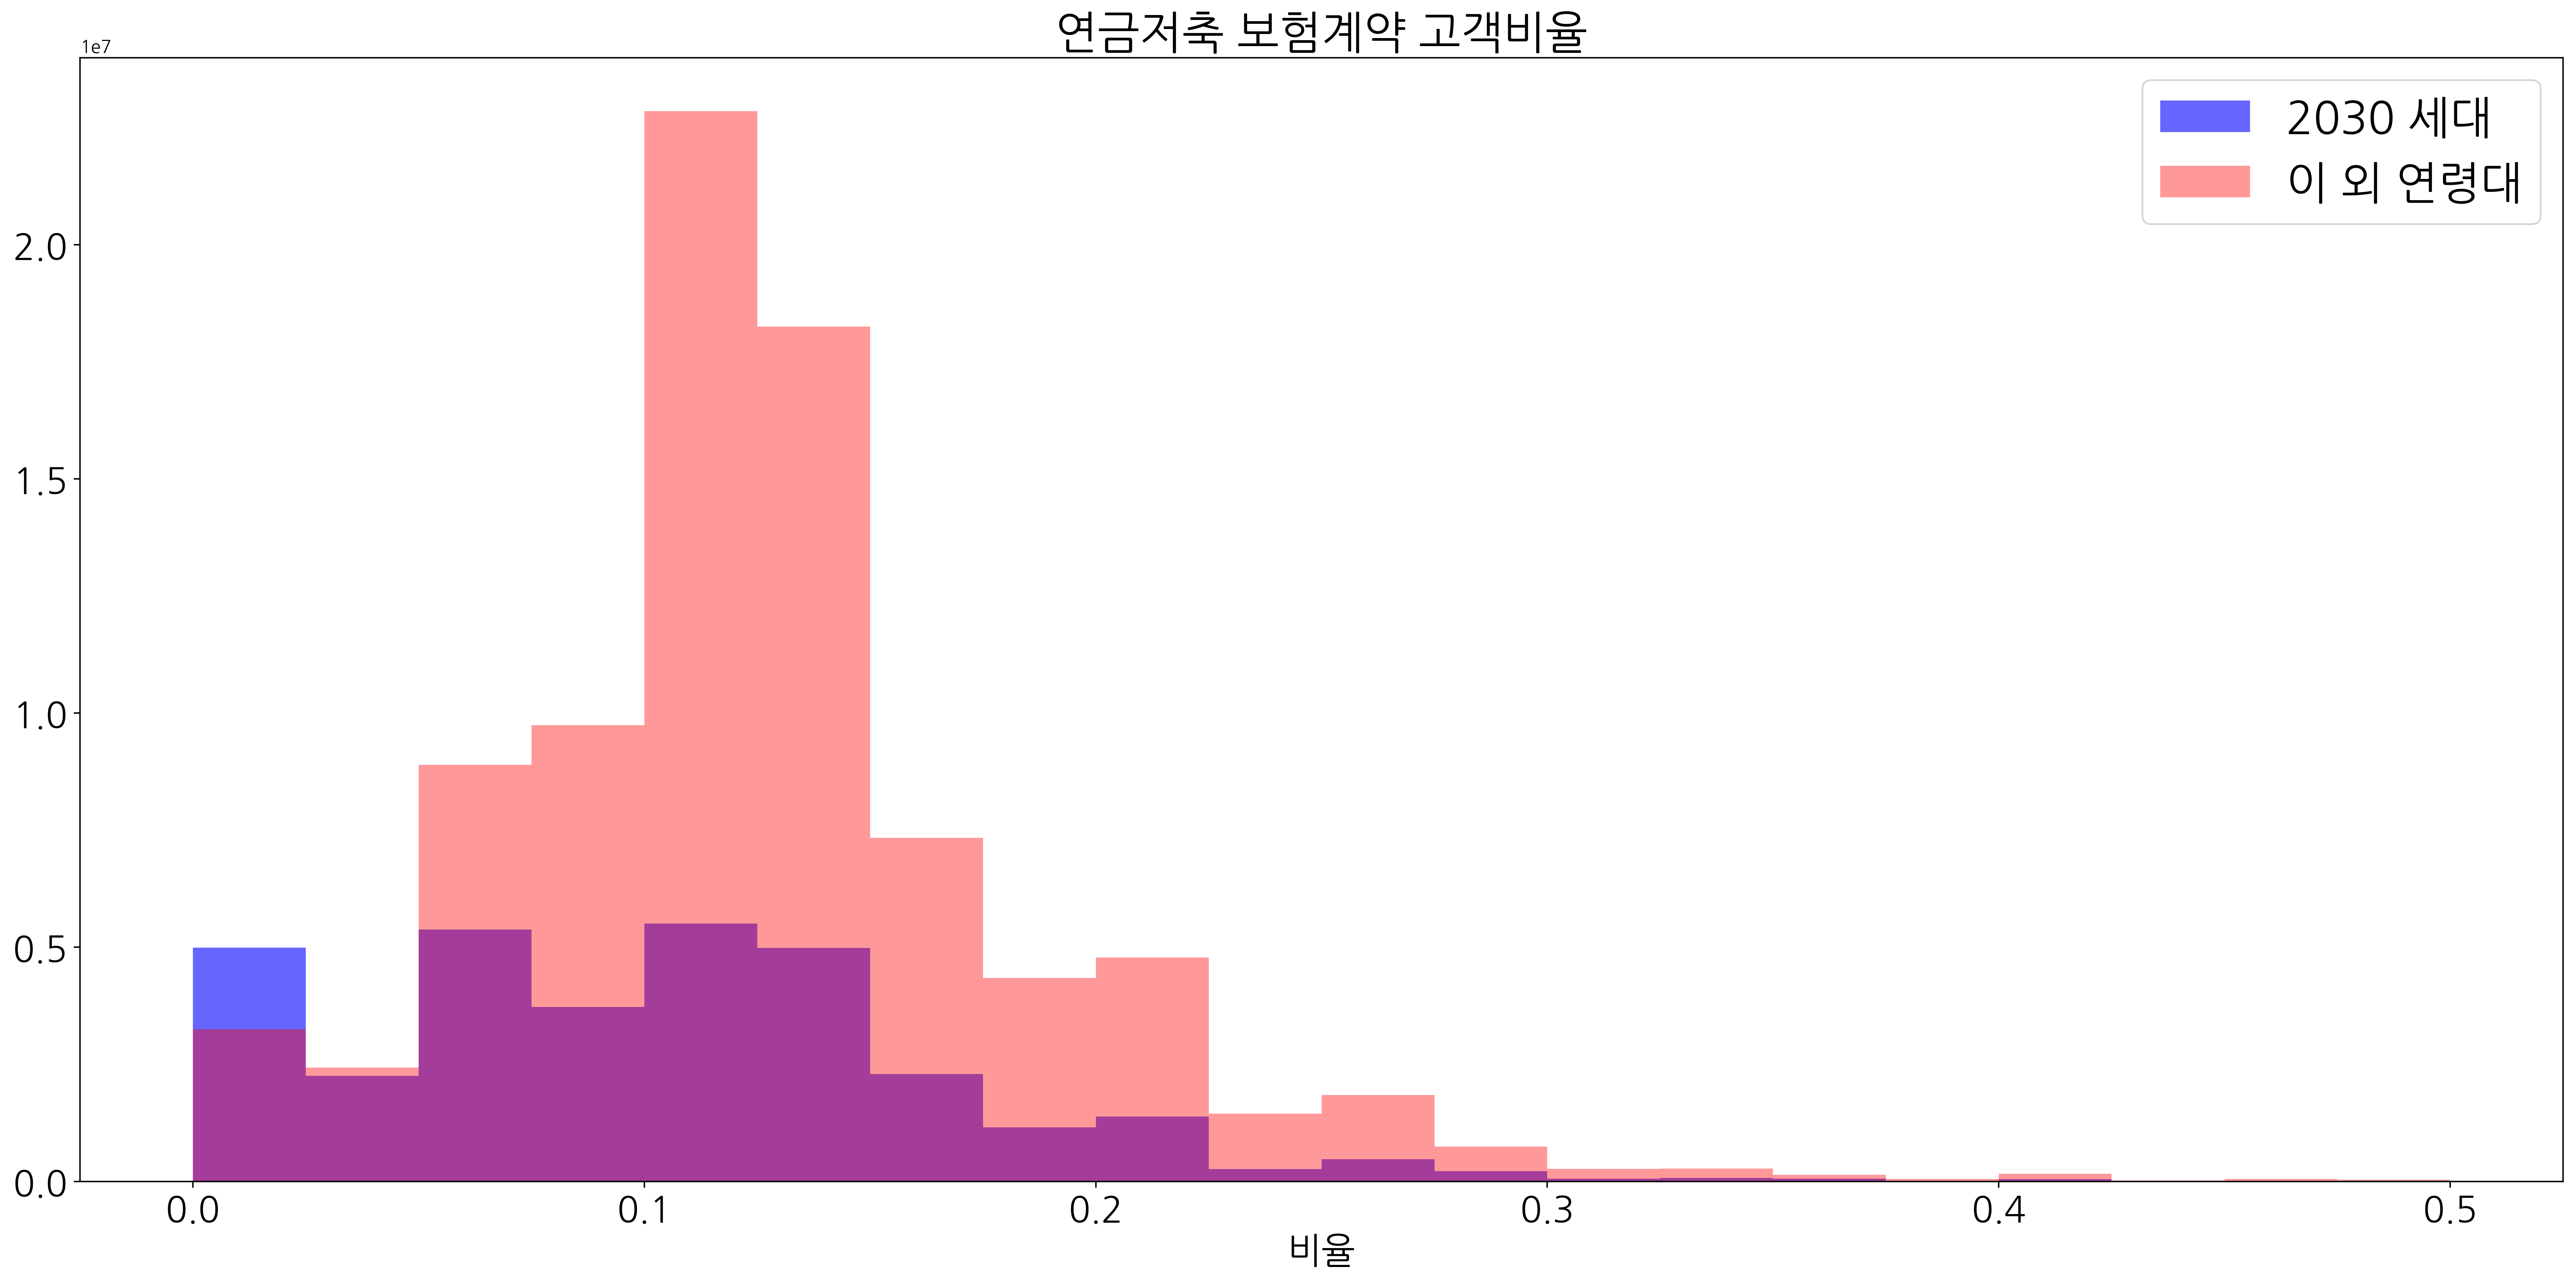

In [156]:
x_range = (0, 0.5)

# young_df와 other_ages_df에서 'young_vs_old'가 'young'인 행과 'old'인 행을 각각 추출
young_df_young = inner_lb05r[inner_lb05r['young_vs_old'] == 'young']
young_df_old = inner_lb05r[inner_lb05r['young_vs_old'] == 'old']


# 각각의 히스토그램을 그릴 때 'value'를 가중치로 사용
plt.figure(figsize=(20, 10), dpi=500)
plt.hist(young_df_young['lb05r'], bins=20, alpha=0.6, label='2030 세대', color='b', weights=young_df_young['value'], range=x_range)
plt.hist(young_df_old['lb05r'], bins=20, alpha=0.4, label='이 외 연령대', color='r', weights=young_df_old['value'], range=x_range)

plt.title('연금저축 보험계약 고객비율', fontsize=25)
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.xlabel('비율', fontsize=20)
plt.legend(fontsize=25)

plt.tick_params(axis='both', labelsize=20)

plt.tight_layout()

plt.savefig('new1.png')

plt.show()